<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_1brkpt_TESTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
%reset -f

### Imports

In [2]:
!pip install rioxarray --quiet
!pip install torchmetrics --quiet
!pip install permetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.0 MB/s eta 0:00:00


In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:

isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_ZS.tif'
projf = '/content/drive/My Drive/Colab Notebooks/Analogs'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test_ZS'
fld3 = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_ZS/Zonal3_Test'
fld4 = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_ZS/Zonal4_Test'
fldM = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_ZS/ZonalM_Test'


### Dunn Score/No Breakpoint

(1281, 2042)
Dunn Index: 0.2784970331329061
Dunn Index: 0.20728878623401406
Dunn Index: 0.21998694455875595
Dunn Index: 0.16225024260399265
Dunn Index: 0.19366659088767493
Dunn Index: 0.17635201216242846
Dunn Index: 0.1500288982928956
Dunn Index: 0.16148020726505788
Dunn Index: 0.17795094181083174
Dunn Index: 0.1356102197619361
Dunn Index: 0.12353135193783138
Dunn Index: 0.13982592662624002
Dunn Index: 0.14629009227782744
Dunn Index: 0.14034275933870832
Dunn Index: 0.12628026389350702


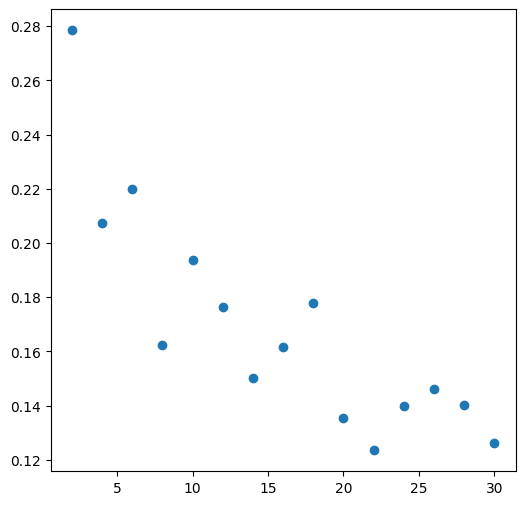

In [41]:
import matplotlib.pyplot as plt
import torch
from torchmetrics.clustering import DunnIndex
import numpy as np
import pandas as pd
import rioxarray as rx
import os

dunn_index = DunnIndex(p=2)

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

com_im = rx.open_rasterio(os.path.join(projf, 'MultidimRasterLyr_d_pc.tif'))
arr = com_im.values
shp = com_im.values.shape
new_arr = []
for i in range(shp[0]):
  filtered_arr = arr[i, :, :][mask]
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
X = torch.tensor(X.astype(float))

for n in test_cluster_sizes:

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  cluster_labels = torch.tensor(cluster_labels.astype(float))
  score = dunn_index(X, cluster_labels)
  test_scores.append(score)

  print(f"Dunn Index: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)

dunn_scores = test_scores


###Dunn Scores/One Breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-3305133069.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


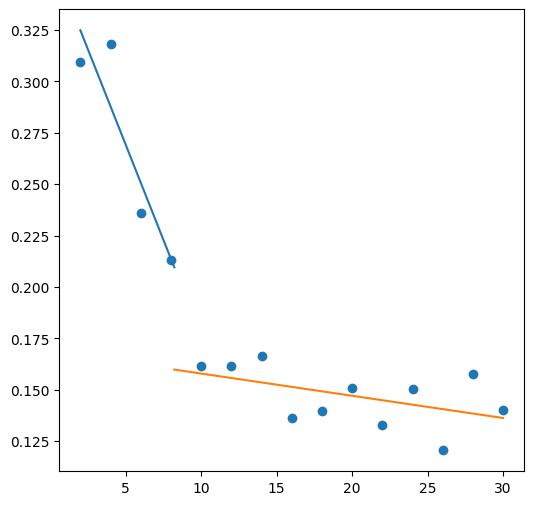

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Silhouette Score/No Breakpoint

Silhouette score: 0.23747934653433678
Silhouette score: 0.1611042185712713
Silhouette score: 0.17591493737084343
Silhouette score: 0.15080370099551377
Silhouette score: 0.15426255621432083
Silhouette score: 0.13766136634032566
Silhouette score: 0.13105157794517822
Silhouette score: 0.11239353609248992
Silhouette score: 0.12374106271413171
Silhouette score: 0.11803900921895645
Silhouette score: 0.11176268088541493
Silhouette score: 0.11373372261009146
Silhouette score: 0.10895461509089042
Silhouette score: 0.11191050891619499
Silhouette score: 0.10499693606818981


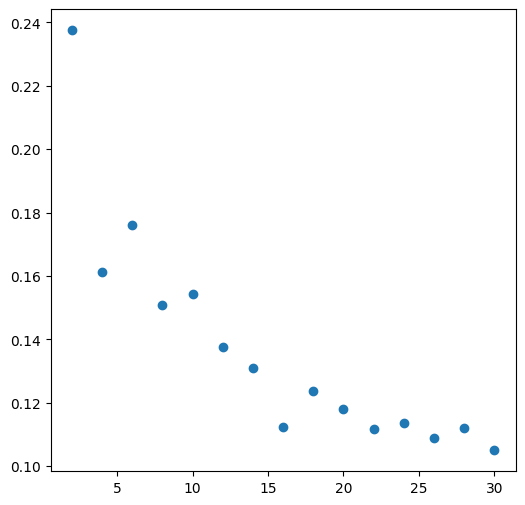

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os



iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)

com_im = rx.open_rasterio(os.path.join(projf, 'MultidimRasterLyr_d_pc.tif'))
arr = com_im.values
shp = com_im.values.shape
new_arr = []
for i in range(shp[0]):
  filtered_arr = arr[i, :, :][mask]
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

  print(f"Silhouette score: {avg_score}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)

silhouette_scores = test_scores

###Silhouette Score/One Breakpoint

Optimal breakpoint 1: 14.222222222222221


/tmp/ipython-input-3164484002.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


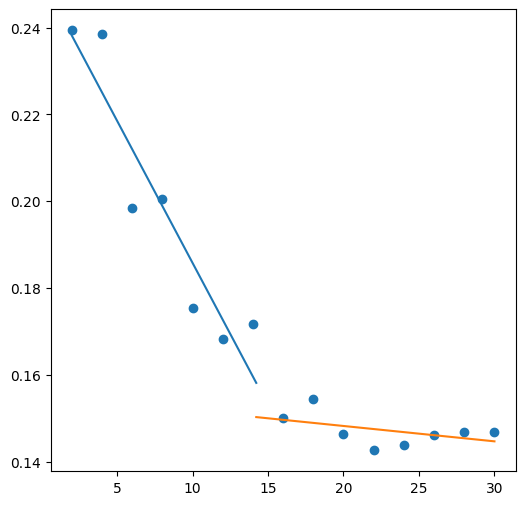

In [ ]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


### Within-cluster Sum of Squares

In [43]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import rioxarray as rx
import os



iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)

com_im = rx.open_rasterio(os.path.join(projf, 'MultidimRasterLyr_d_pc.tif'.format(n)))
arr = com_im.values
shp = com_im.values.shape
new_arr = []
for i in range(shp[0]):
  filtered_arr = arr[i, :, :][mask]
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
print(X.shape)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr

  sum_squared_distances = 0

  label_idxs = []
  for i in range(n):
    label_idxs = []
    for j in range(len(cluster_labels)):
      if cluster_labels[j] == i + 1:
        label_idxs.append(j)

    labels = cluster_labels[label_idxs]
    label_X = X[label_idxs,:]

    for j in range(8):
      centroid_coord = np.mean(label_X[:,j])

      for x in label_X[:, j]:
        sum_squared_distances += (x - centroid_coord)**2

  sqroot_squared_distances = sum_squared_distances**0.5

  print(sqroot_squared_distances)

  test_scores.append(sqroot_squared_distances)

wcss_scores = test_scores


(1623570, 12)
4203.084232599645
3691.962737978683
3364.5944595874703
3166.1167054053017
2994.2187747389958
2901.204841024548
2816.3670561465647
2760.922543774325
2677.93282717759
2635.269500698593
2606.486110549365
2547.47821630661
2527.9742533301355
2479.36899864083
2453.393087311595


### Within-cluster Sum of Squares/One Breakpoint

Optimal breakpoint 1: 6.000001116801738


/tmp/ipython-input-597286820.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


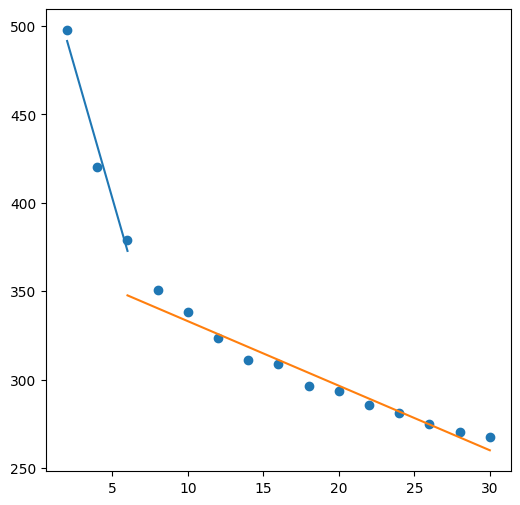

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###My Purity Score/No Breakpoint

['Zonal_eco3_28.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_2.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_30.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_24.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,0,8960,0,0,0,0,0,0,0,0,0,0,0,0,47298
1,2,45,19966,0,0,182,0,336,136,167,0,0,0,149,0,31575
2,3,50919,132,45,41,204,24,2437,80,104,0,65,2,0,410,0
3,4,1635,599,0,2,3216,0,13520,2699,56236,21,461,0,13758,0,848
4,5,44,11643,0,0,7,0,196,43,414,0,0,0,66,0,30870
5,6,91,778,0,1,14,0,407,10703,1984,7,9,0,21023,0,13598
6,7,36250,677,0,0,25088,0,35317,77,2846,0,0,0,208,345,1
7,8,37072,63,0,2,17412,0,24446,0,8729,0,0,0,56,58,0
8,9,12678,18514,22,7,1815,0,1081,1,2268,0,0,0,223,2,134
9,10,6873,7,1,18,28632,63,22411,419,495,0,82,2,1,453,0


Purity Score: 0.7998537671287724
Purity Score: 0.6946178418886338
Purity Score: 0.6379436726256253
Purity Score: 0.5442850296715982
Purity Score: 0.48853174559176266
Purity Score: 0.4468128748988258
Purity Score: 0.3927658463088827
Purity Score: 0.3821211527634563
Purity Score: 0.34263458167173616
Purity Score: 0.31494150069174187
Purity Score: 0.2995322272855508
Purity Score: 0.29734119812398135
Purity Score: 0.2859542526416161
Purity Score: 0.283130615397693
Purity Score: 0.267975740373208
['Zonal_mlra_26.csv', 'Zonal_mlra_22.csv', 'Zonal_mlra_12.csv', 'Zonal_mlra_18.csv', 'Zonal_mlra_8.csv', 'Zonal_mlra_16.csv', 'Zonal_mlra_4.csv', 'Zonal_mlra_24.csv', 'Zonal_mlra_6.csv', 'Zonal_mlra_20.csv', 'Zonal_mlra_2.csv', 'Zonal_mlra_10.csv', 'Zonal_mlra_28.csv', 'Zonal_mlra_14.csv', 'Zonal_mlra_30.csv']


,LABEL,MLRA__12,MLRA__14,MLRA__22,MLRA__24,MLRA__25,MLRA__26,MLRA__27,MLRA__28,MLRA__29,...,MLRA__50,MLRA__51,MLRA__52,MLRA__55,MLRA__84,MLRA__85,MLRA__93,MLRA__94,MLRA__95,MLRA__96
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,81,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,20,0,242,1712,45,25,6917,30979,...,0,7,0,0,1,0,0,0,0,0
3,4,0,2,7,6,71,5,169,1716,1266,...,16,11,1,0,0,89,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0,7,25,259,3,318,782,160,...,1,192,139,1,0,0,0,0,0,0
6,7,0,0,0,226,2458,103,303,4757,12939,...,0,63,0,4,0,0,0,0,0,0
7,8,0,0,0,79,643,12,413,16378,5857,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,75,813,0,370,1412,1092,...,0,13,124,0,0,0,0,0,0,0
9,10,0,0,0,1004,3090,106,2082,10674,3218,...,18,600,631,1,0,0,0,0,0,0


Purity Score: 0.8002822408767577
Purity Score: 0.6936306697646227
Purity Score: 0.6608914672336944
Purity Score: 0.574840030651039
Purity Score: 0.5366666748796995
Purity Score: 0.5010379220369636
Purity Score: 0.4567589975829044
Purity Score: 0.432034893891721
Purity Score: 0.40716110767532565
Purity Score: 0.37328604268970256
Purity Score: 0.36098127674882163
Purity Score: 0.36350432046597464
Purity Score: 0.3494384749383407
Purity Score: 0.3331655821356678
Purity Score: 0.31428525670245083
['Zonal_eco4_20.csv', 'Zonal_eco4_16.csv', 'Zonal_eco4_18.csv', 'Zonal_eco4_2.csv', 'Zonal_eco4_24.csv', 'Zonal_eco4_28.csv', 'Zonal_eco4_22.csv', 'Zonal_eco4_14.csv', 'Zonal_eco4_6.csv', 'Zonal_eco4_12.csv', 'Zonal_eco4_10.csv', 'Zonal_eco4_30.csv', 'Zonal_eco4_26.csv', 'Zonal_eco4_4.csv', 'Zonal_eco4_8.csv']


,LABEL,US_L4_13a,US_L4_13aa,US_L4_13ac,US_L4_13b,US_L4_13c,US_L4_13d,US_L4_13e,US_L4_13f,US_L4_13g,...,US_L4_80l,US_L4_81d,US_L4_81g,US_L4_81i,US_L4_81j,US_L4_81k,US_L4_81l,US_L4_81m,US_L4_81n,US_L4_81o
0,1,0,0,0,0,0,0,0,0,10,...,0,1084,2807,8946,31463,3511,6776,1087,6226,1813
1,2,18079,4,0,10448,242,0,0,0,814,...,81,0,0,0,0,0,0,0,0,0
2,3,9520,212,0,1576,1497,2,0,2766,1545,...,55,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,43,0,0,2,...,0,0,50,507,603,27492,24525,2,3132,902
4,5,16,1247,25,252,1693,1536,12,0,5,...,30,0,2,94,14,343,17,0,9,1
5,6,1170,746,34,13082,4230,4,0,0,204,...,235,0,0,0,0,0,0,0,0,0
6,7,258,202,13,2836,386,46,0,0,191,...,15,0,0,0,0,0,0,0,0,0
7,8,0,98,0,60,18,269,0,0,3,...,0,0,7,0,0,79,1219,0,1,0
8,9,99,664,8,6188,6111,276,0,0,25,...,379,0,0,0,0,0,0,0,0,0
9,10,326,2725,0,8390,13485,258,0,375,127,...,575,0,167,0,13,3,42,0,29,14


Purity Score: 0.8912142009734896
Purity Score: 0.7797944855300911
Purity Score: 0.7679794362334749
Purity Score: 0.7127996264717223
Purity Score: 0.6711583688443907
Purity Score: 0.6268166693153665
Purity Score: 0.6051558482676886
Purity Score: 0.6141638916915829
Purity Score: 0.5841898489501909
Purity Score: 0.5573794625972781
Purity Score: 0.5226272885074761
Purity Score: 0.5297633787061778
Purity Score: 0.5282831866692784
Purity Score: 0.5226439198786772
Purity Score: 0.5024990175171458


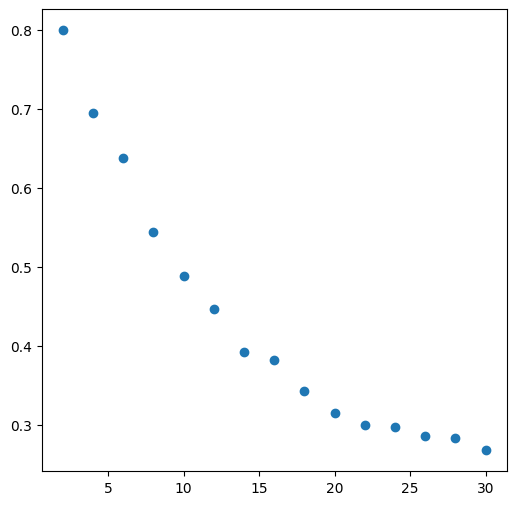

In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = fld3

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)


purity_eco3 = test_scores






fld = fldM

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


purity_mlra = test_scores









fld = fld4

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


purity_eco4 = test_scores




### Purity Score/No Breakpoint (Not Used)

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,252501,73896,216,798,108707,328,155885,14602,89191,16085,32191,0,27137,5657,124004
1,2,192545,2525,4319,65041,39873,39327,42169,141352,10972,29636,69024,1398,27127,56102,830


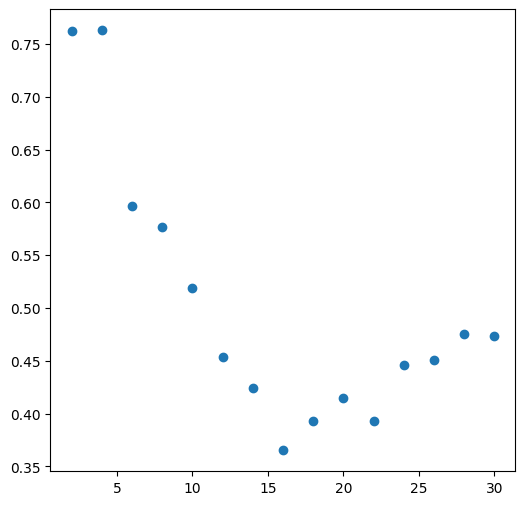

In [ ]:
import os
import permetrics
from permetrics import ClusteringMetric
import pandas as pd
import matplotlib.pyplot as plt


'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco3_{}.csv'.format(n)))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  arr = df.to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.purity_score())


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Purity Score/One Breakpoint

Optimal breakpoint 1: 12.222222222222221


/tmp/ipython-input-1430848010.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


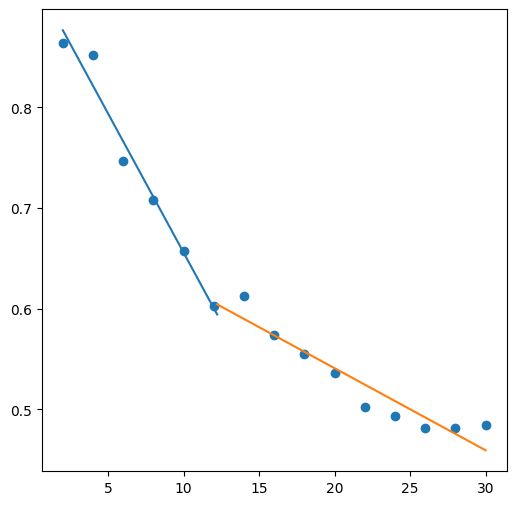

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###My Entropy Score/No Breakpoint

['Zonal_eco3_28.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_2.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_30.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_24.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,0,8960,0,0,0,0,0,0,0,0,0,0,0,0,47298
1,2,45,19966,0,0,182,0,336,136,167,0,0,0,149,0,31575
2,3,50919,132,45,41,204,24,2437,80,104,0,65,2,0,410,0
3,4,1635,599,0,2,3216,0,13520,2699,56236,21,461,0,13758,0,848
4,5,44,11643,0,0,7,0,196,43,414,0,0,0,66,0,30870
5,6,91,778,0,1,14,0,407,10703,1984,7,9,0,21023,0,13598
6,7,36250,677,0,0,25088,0,35317,77,2846,0,0,0,208,345,1
7,8,37072,63,0,2,17412,0,24446,0,8729,0,0,0,56,58,0
8,9,12678,18514,22,7,1815,0,1081,1,2268,0,0,0,223,2,134
9,10,6873,7,1,18,28632,63,22411,419,495,0,82,2,1,453,0


['Zonal_mlra_26.csv', 'Zonal_mlra_22.csv', 'Zonal_mlra_12.csv', 'Zonal_mlra_18.csv', 'Zonal_mlra_8.csv', 'Zonal_mlra_16.csv', 'Zonal_mlra_4.csv', 'Zonal_mlra_24.csv', 'Zonal_mlra_6.csv', 'Zonal_mlra_20.csv', 'Zonal_mlra_2.csv', 'Zonal_mlra_10.csv', 'Zonal_mlra_28.csv', 'Zonal_mlra_14.csv', 'Zonal_mlra_30.csv']


/tmp/ipython-input-4054828724.py:40: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-4054828724.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


,LABEL,MLRA__12,MLRA__14,MLRA__22,MLRA__24,MLRA__25,MLRA__26,MLRA__27,MLRA__28,MLRA__29,...,MLRA__50,MLRA__51,MLRA__52,MLRA__55,MLRA__84,MLRA__85,MLRA__93,MLRA__94,MLRA__95,MLRA__96
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,81,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,20,0,242,1712,45,25,6917,30979,...,0,7,0,0,1,0,0,0,0,0
3,4,0,2,7,6,71,5,169,1716,1266,...,16,11,1,0,0,89,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0,7,25,259,3,318,782,160,...,1,192,139,1,0,0,0,0,0,0
6,7,0,0,0,226,2458,103,303,4757,12939,...,0,63,0,4,0,0,0,0,0,0
7,8,0,0,0,79,643,12,413,16378,5857,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,75,813,0,370,1412,1092,...,0,13,124,0,0,0,0,0,0,0
9,10,0,0,0,1004,3090,106,2082,10674,3218,...,18,600,631,1,0,0,0,0,0,0


/tmp/ipython-input-4054828724.py:94: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-4054828724.py:94: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


['Zonal_eco4_20.csv', 'Zonal_eco4_16.csv', 'Zonal_eco4_18.csv', 'Zonal_eco4_2.csv', 'Zonal_eco4_24.csv', 'Zonal_eco4_28.csv', 'Zonal_eco4_22.csv', 'Zonal_eco4_14.csv', 'Zonal_eco4_6.csv', 'Zonal_eco4_12.csv', 'Zonal_eco4_10.csv', 'Zonal_eco4_30.csv', 'Zonal_eco4_26.csv', 'Zonal_eco4_4.csv', 'Zonal_eco4_8.csv']


,LABEL,US_L4_13a,US_L4_13aa,US_L4_13ac,US_L4_13b,US_L4_13c,US_L4_13d,US_L4_13e,US_L4_13f,US_L4_13g,...,US_L4_80l,US_L4_81d,US_L4_81g,US_L4_81i,US_L4_81j,US_L4_81k,US_L4_81l,US_L4_81m,US_L4_81n,US_L4_81o
0,1,0,0,0,0,0,0,0,0,10,...,0,1084,2807,8946,31463,3511,6776,1087,6226,1813
1,2,18079,4,0,10448,242,0,0,0,814,...,81,0,0,0,0,0,0,0,0,0
2,3,9520,212,0,1576,1497,2,0,2766,1545,...,55,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,43,0,0,2,...,0,0,50,507,603,27492,24525,2,3132,902
4,5,16,1247,25,252,1693,1536,12,0,5,...,30,0,2,94,14,343,17,0,9,1
5,6,1170,746,34,13082,4230,4,0,0,204,...,235,0,0,0,0,0,0,0,0,0
6,7,258,202,13,2836,386,46,0,0,191,...,15,0,0,0,0,0,0,0,0,0
7,8,0,98,0,60,18,269,0,0,3,...,0,0,7,0,0,79,1219,0,1,0
8,9,99,664,8,6188,6111,276,0,0,25,...,379,0,0,0,0,0,0,0,0,0
9,10,326,2725,0,8390,13485,258,0,375,127,...,575,0,167,0,13,3,42,0,29,14


/tmp/ipython-input-4054828724.py:150: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-4054828724.py:150: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


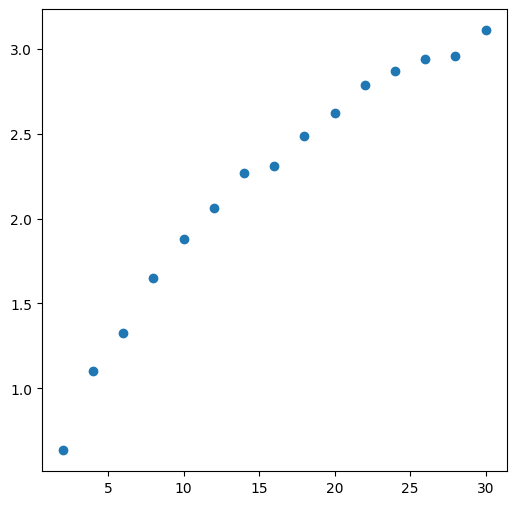

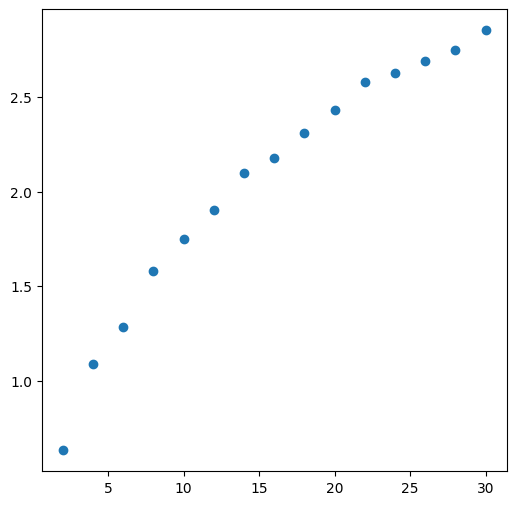

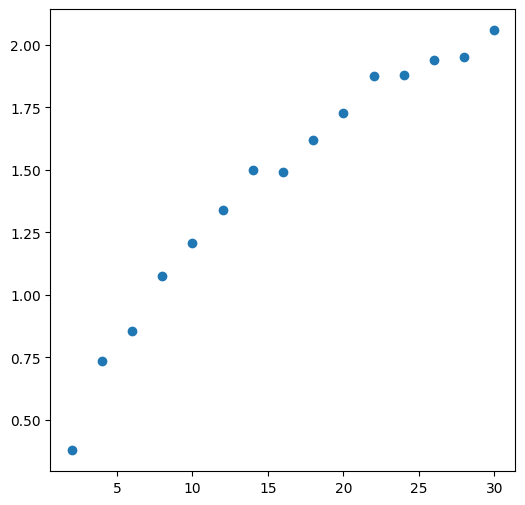

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fld = fld3

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(-entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

entropy_eco3 = test_scores








fld = fldM

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(-entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

entropy_mlra = test_scores










fld = fld4

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(-entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

entropy_eco4 = test_scores







### Entropy Score/No Breakpoint (Not Used)

['Zonal_eco4_2.csv', 'Zonal_eco4_4.csv', 'Zonal_eco4_6.csv', 'Zonal_eco4_8.csv', 'Zonal_eco4_10.csv', 'Zonal_eco4_12.csv', 'Zonal_eco4_14.csv', 'Zonal_eco4_16.csv', 'Zonal_eco4_18.csv', 'Zonal_eco4_20.csv', 'Zonal_eco4_22.csv', 'Zonal_eco4_24.csv', 'Zonal_eco4_26.csv', 'Zonal_eco4_28.csv', 'Zonal_eco4_30.csv']


,LABEL,US_L4_13a,US_L4_13aa,US_L4_13ac,US_L4_13b,US_L4_13c,US_L4_13d,US_L4_13e,US_L4_13f,US_L4_13g,...,US_L4_80l,US_L4_81d,US_L4_81g,US_L4_81i,US_L4_81j,US_L4_81k,US_L4_81l,US_L4_81m,US_L4_81n,US_L4_81o
0,1,19271,4029,78,37471,17117,1948,0,0,1244,...,1100,1084,2659,9544,31905,32668,32926,1089,9399,2730
1,2,10330,4278,2,6629,22599,25639,4039,3537,1808,...,337,0,374,3,188,235,30,0,0,0


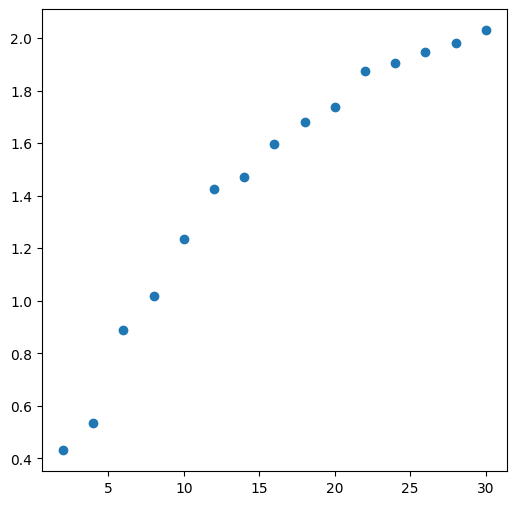

In [ ]:
from permetrics import ClusteringMetric

'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal4_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco4_{}.csv'.format(n)))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  arr = df.to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.entropy_score())


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Entropy Score/One Breakpoint

Optimal breakpoint 1: 12.222222222222221


/tmp/ipython-input-2898114523.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


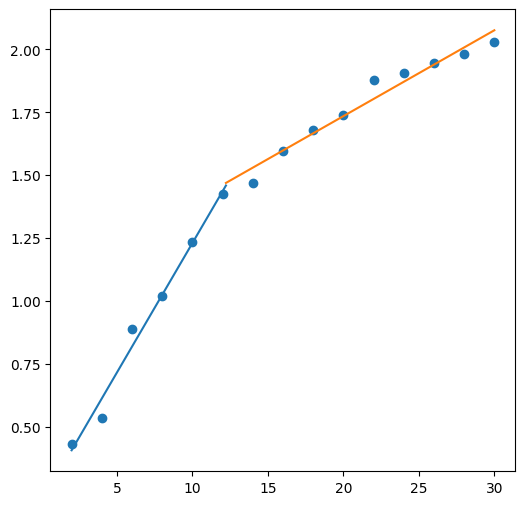

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



### Panel Figure

/tmp/ipython-input-1758810444.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


Optimal breakpoint 1: 9.677677677677679
8.713578619527482
Optimal breakpoint 1: 6.022022022022022
6.796768585327301
Optimal breakpoint 1: 8.004004004004004
6.759308510518427
Optimal breakpoint 1: 12.012012012012011
13.060092311758492
Optimal breakpoint 1: 10.008008008008009
10.976797029179586
Optimal breakpoint 1: 12.012012012012011
13.037551572675774
Optimal breakpoint 1: 10.008008008008009
10.780480490610506
Optimal breakpoint 1: 10.008008008008009
11.439015567441771
Optimal breakpoint 1: 10.008008008008009
10.98346675504599


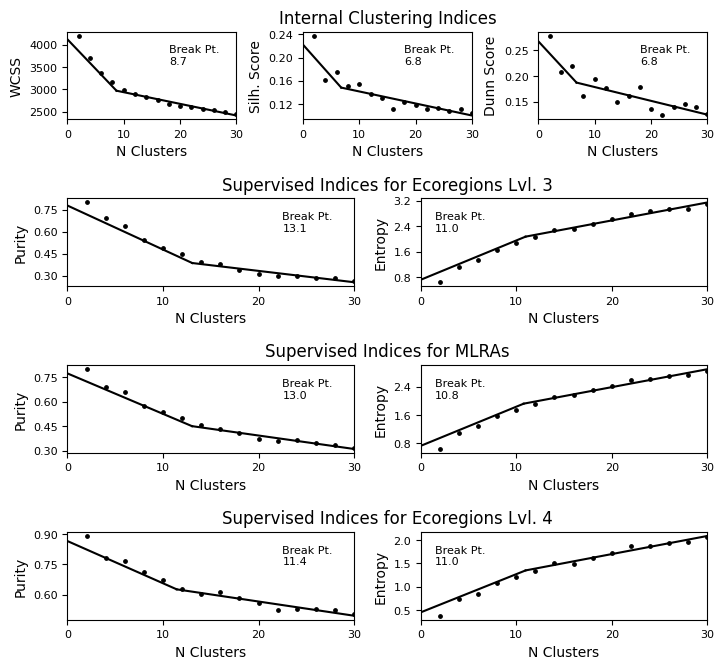

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=1000):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

#test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

fig = plt.figure(figsize=(8, 6))



ghost = fig.add_gridspec(4, 6)
ghost.update(left=0.1, right=0.9, top=0.99, bottom=0.01, wspace=1.3, hspace=0.9)
axg1 = fig.add_subplot(ghost[0,0:2])
axg2 = fig.add_subplot(ghost[0,2:4])
axg3 = fig.add_subplot(ghost[0,4:])
axg4 = fig.add_subplot(ghost[1,0:2])
axg5 = fig.add_subplot(ghost[1,2:4])
axg6 = fig.add_subplot(ghost[1,4:])
axg7 = fig.add_subplot(ghost[2,0:2])
axg8 = fig.add_subplot(ghost[2,2:4])
axg9 = fig.add_subplot(ghost[2,4:])
axg10 = fig.add_subplot(ghost[3,0:2])
axg11 = fig.add_subplot(ghost[3,2:4])
axg12 = fig.add_subplot(ghost[3,4:])
axg1.set_axis_off()
axg2.set_axis_off()
axg3.set_axis_off()
axg4.set_axis_off()
axg5.set_axis_off()
axg6.set_axis_off()
axg7.set_axis_off()
axg8.set_axis_off()
axg9.set_axis_off()
axg10.set_axis_off()
axg11.set_axis_off()
axg12.set_axis_off()



gs = fig.add_gridspec(4, 6)
gs.update(left=0.1, right=0.9, top=0.99, bottom=0.01, wspace=1.3, hspace=0.9)
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:])
ax4 = fig.add_subplot(gs[1,:3])
ax5 = fig.add_subplot(gs[1,3:])
ax6 = fig.add_subplot(gs[2,:3])
ax7 = fig.add_subplot(gs[2,3:])
ax8 = fig.add_subplot(gs[3,:3])
ax9 = fig.add_subplot(gs[3,3:])



axwut = fig.add_subplot(ghost[:])
axwut.axis('off')
axwut.set_title('Internal Clustering Indices')

#axg2.set_title('Internal Indices')
axg5.set_title('Supervised Indices for Ecoregions Lvl. 3')
axg8.set_title('Supervised Indices for MLRAs')
axg11.set_title('Supervised Indices for Ecoregions Lvl. 4')

ax1.set_ylabel('WCSS')
ax2.set_ylabel('Silh. Score')
ax3.set_ylabel('Dunn Score')
ax4.set_ylabel('Purity')
ax5.set_ylabel('Entropy')
ax6.set_ylabel('Purity')
ax7.set_ylabel('Entropy')
ax8.set_ylabel('Purity')
ax9.set_ylabel('Entropy')

ax1.set_xlabel('N Clusters')
ax2.set_xlabel('N Clusters')
ax3.set_xlabel('N Clusters')
ax4.set_xlabel('N Clusters')
ax5.set_xlabel('N Clusters')
ax6.set_xlabel('N Clusters')
ax7.set_xlabel('N Clusters')
ax8.set_xlabel('N Clusters')
ax9.set_xlabel('N Clusters')

scores = [wcss_scores, silhouette_scores, dunn_scores, purity_eco3, entropy_eco3, purity_mlra, entropy_mlra, purity_eco4, entropy_eco4]
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i, ax in enumerate(axes):

  ax.tick_params(axis='x', labelsize=8)
  ax.tick_params(axis='y', labelsize=8)
  ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
  custom_xticks = [0, 10, 20, 30]
  ax.set_xticks(custom_xticks)
  ax.set_xlim(0, 30)

  x_data = np.array([float(x) for x in test_cluster_sizes])
  y_data = np.array([float(x) for x in scores[i]])

  optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
  b1, m1, c1, m2, c2 = optimal_params

  print('Optimal breakpoint 1:', optimal_b1)

  breakpt = (c2 - c1)/(m1 - m2)
  print(breakpt)
  ax.scatter(x_data, y_data, s=6, c='black')
  ax.plot([0, breakpt], [m1*min(x_data) + c1, m1*breakpt + c1], c='black')
  ax.plot([breakpt, max(x_data)], [m2*breakpt + c2, m2*max(x_data) + c2], c='black')

  if i in [0, 1, 2]:
    ax.text(0.6, 0.85, "Break Pt.\n{}".format(str(round(breakpt, 1))),
            transform=ax.transAxes, ha='left', va='top', fontsize=8)

  if i in [3, 5, 7]:
    ax.text(0.75, 0.85, "Break Pt.\n{}".format(str(round(breakpt, 1))),
            transform=ax.transAxes, ha='left', va='top', fontsize=8)

  if i in [4, 6, 8]:
    ax.text(0.05, 0.85, "Break Pt.\n{}".format(str(round(breakpt, 1))),
            transform=ax.transAxes, ha='left', va='top', fontsize=8)





